# Smoke Detector

## Introduction

Many states in America require homes to have smoke detectors, as fire has caused thousands of deaths in the country. Between 2011 and 2019, fire-related deaths accounted for approximately 7% of the U.S. population [1]. Having a working and sensitive smoke detector can save lives.

Smoke detectors are not limited to homes; they can be used in manufacturing facilities, school buildings, and other locations.

Smoke detectors work by detecting particles in the air. There are two types of smoke detectors: ionization and photoelectric. Ionization detectors detect current reduction as particles get trapped between the two plates in the detector. Photoelectric detectors detect the amount of light bounce when there are no particles present and when there are particles present [2]. In this project, we analyze data from photoelectric smoke detectors.

Project goal: to build a model to predict the state of the alarm on or off using the window of sensor data preceding the prediction."

## 1. Libraries

In [1]:
# Data processsing
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from matplotlib.pyplot import figure
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

# Setting seed for reproducibility
np.random.seed(100)  
PYTHONHASHSEED = 0

## 2. Data

The data used in this project is smoke detection dataset from [Kaggle](https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset).
<br/><br/>
The dataset features in detail:

* Air Temperature
* Air Humidity
* TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
* eCO2: co2 equivalent concentration; calculated from different values like TVCO
* Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
* Raw Ethanol: raw ethanol gas (Source)
* Air Pressure
* PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
* Fire Alarm: ground truth is "1" if a fire is there
* CNT: Sample counter
* UTC: Timestamp UTC seconds
* NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);

In [2]:
df = pd.read_csv("smoke_detection_iot.csv")
df

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,62625,1655130047,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
62626,62626,1655130048,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
62627,62627,1655130049,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
62628,62628,1655130050,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,62630.0,3.131450e+04,18079.868017,0.000000e+00,1.565725e+04,3.131450e+04,4.697175e+04,6.262900e+04
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04


## 3. Data Exploration

### 3a. Missing & Duplicate Data

In [5]:
# Check for missing data
df.isna().sum()

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

In [6]:
# Check for null values
df.isnull().values.any()

False

In [7]:
# Check for duplicates
df.duplicated().sum()

0

### 3b. Correlation

In [8]:
df.corr()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
Unnamed: 0,1.000000,0.551987,0.425636,-0.498121,0.248813,0.160665,-0.232854,0.083094,-0.580829,0.151785,0.128487,0.162053,0.126418,0.100300,-0.053262,-0.361351
UTC,0.551987,1.000000,-0.164174,-0.391907,0.180731,0.132100,-0.151088,0.166555,-0.434375,0.123168,0.105304,0.130288,0.103695,0.083234,-0.251595,-0.389404
Temperature[C],0.425636,-0.164174,1.000000,-0.243986,0.082442,0.079265,-0.135540,-0.037343,-0.251203,0.037330,0.032084,0.039291,0.031608,0.025526,-0.089850,-0.163902
Humidity[%],-0.498121,-0.391907,-0.243986,1.000000,-0.488878,-0.369095,0.247199,0.068782,0.694614,-0.236538,-0.178882,-0.277389,-0.174224,-0.118502,0.251965,0.399846
TVOC[ppb],0.248813,0.180731,0.082442,-0.488878,1.000000,0.606118,-0.653053,-0.673715,-0.220004,0.597366,0.477424,0.670657,0.467386,0.344721,-0.057703,-0.214743
eCO2[ppm],0.160665,0.132100,0.079265,-0.369095,0.606118,1.000000,-0.682785,-0.506695,-0.326043,0.665482,0.572691,0.699604,0.564252,0.456323,-0.106681,-0.097006
Raw H2,-0.232854,-0.151088,-0.135540,0.247199,-0.653053,-0.682785,1.000000,0.631495,0.303090,-0.530714,-0.431079,-0.587769,-0.422626,-0.318518,-0.031036,0.107007
Raw Ethanol,0.083094,0.166555,-0.037343,0.068782,-0.673715,-0.506695,0.631495,1.000000,-0.075926,-0.480698,-0.393192,-0.529186,-0.385720,-0.293351,-0.511995,-0.340652
Pressure[hPa],-0.580829,-0.434375,-0.251203,0.694614,-0.220004,-0.326043,0.303090,-0.075926,1.000000,-0.258938,-0.243071,-0.248657,-0.241148,-0.213390,0.186290,0.249797
PM1.0,0.151785,0.123168,0.037330,-0.236538,0.597366,0.665482,-0.530714,-0.480698,-0.258938,1.000000,0.956118,0.940045,0.949860,0.854901,-0.093700,-0.110552


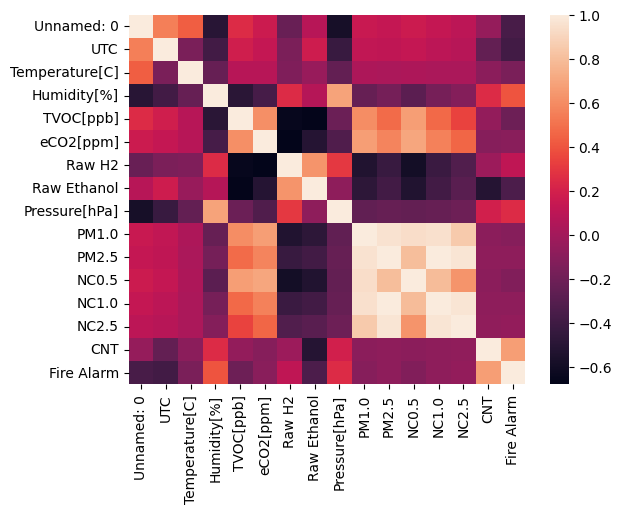

In [9]:
cor_map=round(df.corr(),2)
sns.heatmap(cor_map);

PM1, PM 2.5, NC 0.5, NC1 and NC 2.5 are highly correlated. Therefore, including one from each categlory is good enough.

<AxesSubplot: >

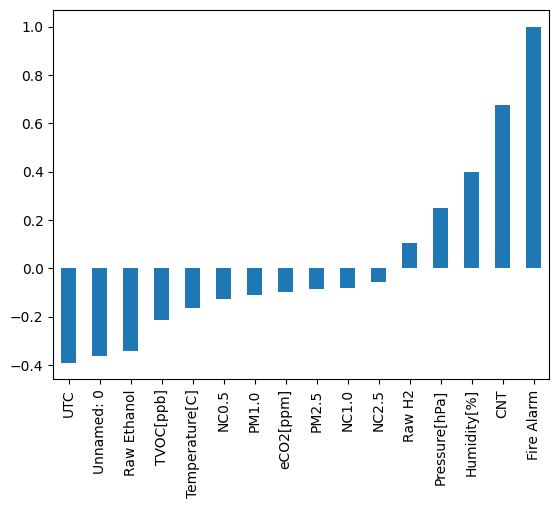

In [10]:
df.corr()['Fire Alarm'].sort_values().plot(kind='bar')

### 3c.Variance Inflation Factor (VIF)

In [11]:
#Calculating VIF
vif_df = pd.DataFrame()
vif_df['variable'] = df.columns 

#VIF for each predictor variable 
vif_df['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

#VIF for each predictor variable 
sorted_vif_df = vif_df.sort_values(by='VIF', ascending=False)
sorted_vif_df

,variable,VIF
12,NC1.0,1.684848e+12
13,NC2.5,6.676945e+11
10,PM2.5,4.599264e+11
9,PM1.0,9.729414e+10
11,NC0.5,7.384040e+10
1,UTC,1.562293e+06
7,Raw Ethanol,1.005360e+01
4,TVOC[ppb],5.976873e+00
14,CNT,4.447293e+00
6,Raw H2,3.531772e+00


* VIF = 1: There is no correlation between the predictor variable and predictor variables.
* VIF between 1 and 5: There is moderate correlation between the predictor variable and other predictor variables.
* VIF > 5: There is severe correlation between a given predictor variable and other predictor variables in the model.
* Conclusion: NCs, PMs and UTC are highly correlated as seen in the heatmap
* *Note: &nbsp; analysis based on the following source: https://www.statology.org/multicollinearity-in-python*

### Data Insights

Anomaly detection refers to the process of identifying unusual patterns or observations in your data that deviate from the expected behavior. In the context of time series data from a smoke detector, we can use anomaly detection techniques to identify abnormal readings from the sensors that may indicate a potential fire.

Potential indicators:
Abnormal readings in temperature or humidity sensors.
Abnormal readings in the levels of smoke or carbon monoxide in the air.
An increase in the frequency of false alarms.
An unexpected change in the pattern of sensor readings.
An outlier in the readings from one or more sensors.

By detecting these anomalies, the smoke detector makes sound to alert users and prevent a fire from occurring.

To build a model that gives prediction about the accuracy of the alarm, we explore the data to understand the relationship between the features and the prediction.

## Data Visualization

In [12]:
# Let y be the Fire Alarm outcome (1:yes, 0:no)
# Let x be the features
y = df['Fire Alarm']
x = df.drop(['Fire Alarm'], axis =1)

In [13]:
Column_list = []
for i in df.columns:
    Column_list.append(i)
features = Column_list[:-1]
features

['Unnamed: 0',
 'UTC',
 'Temperature[C]',
 'Humidity[%]',
 'TVOC[ppb]',
 'eCO2[ppm]',
 'Raw H2',
 'Raw Ethanol',
 'Pressure[hPa]',
 'PM1.0',
 'PM2.5',
 'NC0.5',
 'NC1.0',
 'NC2.5',
 'CNT']

Unnamed: 0


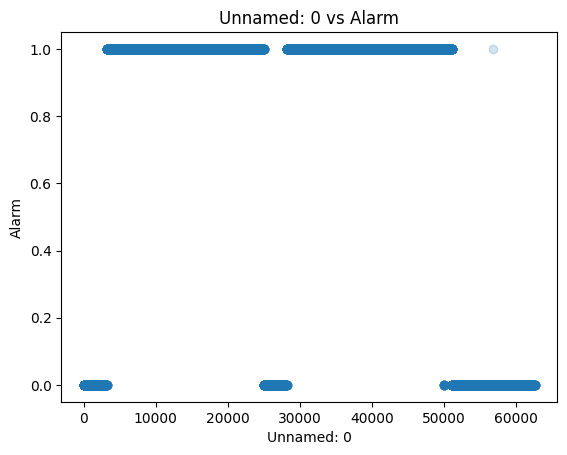

UTC


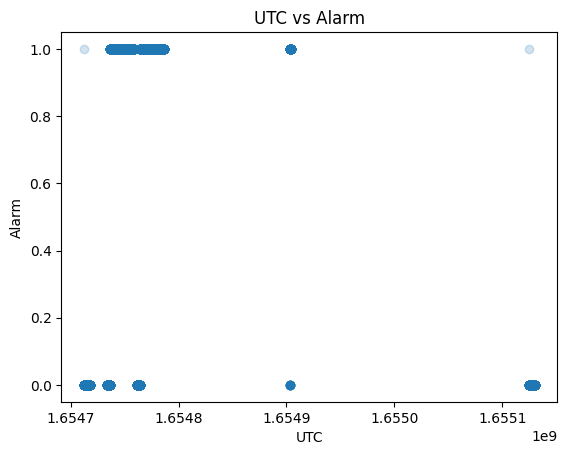

Temperature[C]


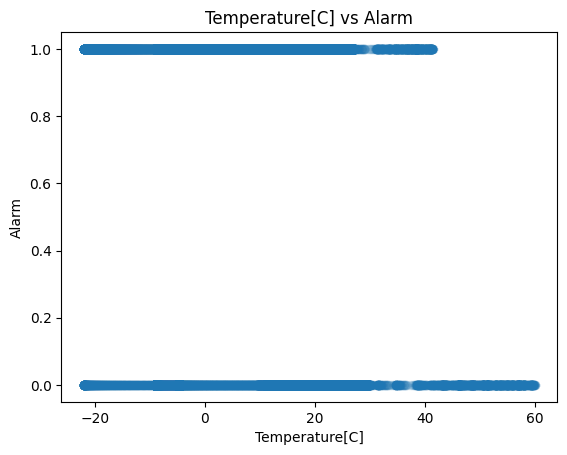

Humidity[%]


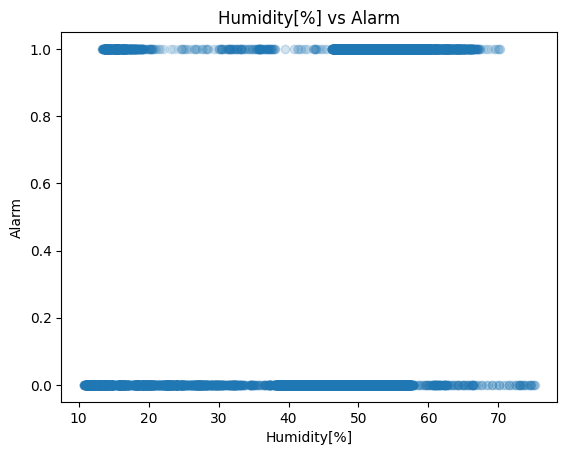

TVOC[ppb]


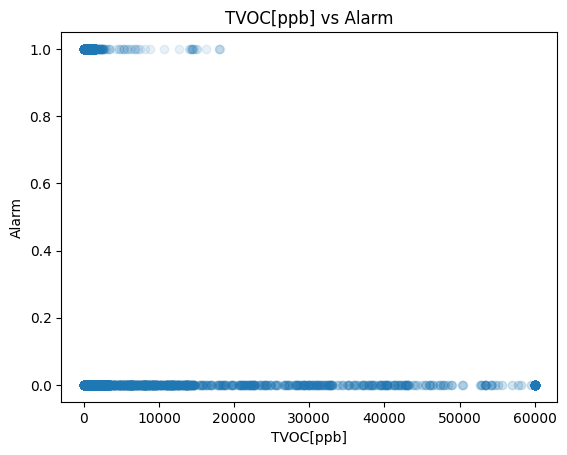

eCO2[ppm]


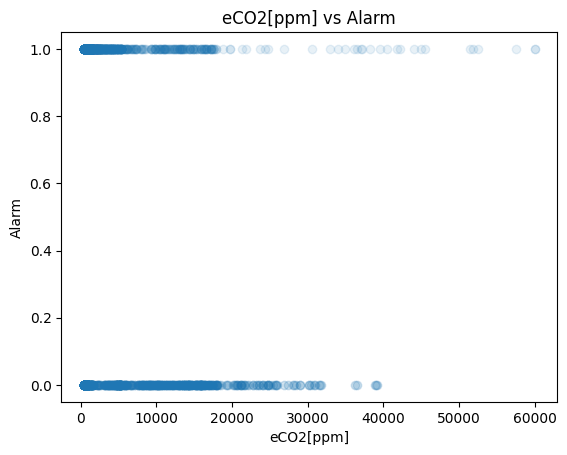

Raw H2


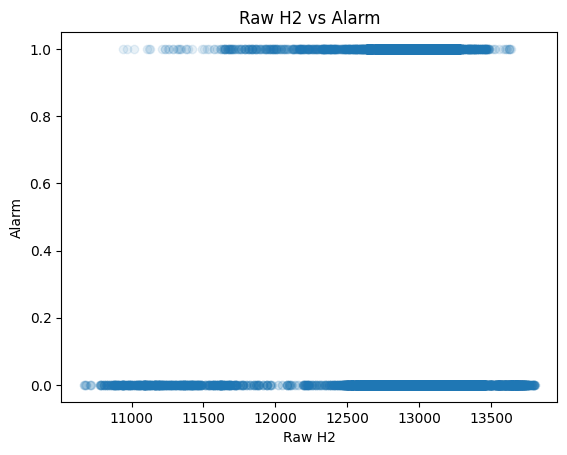

Raw Ethanol


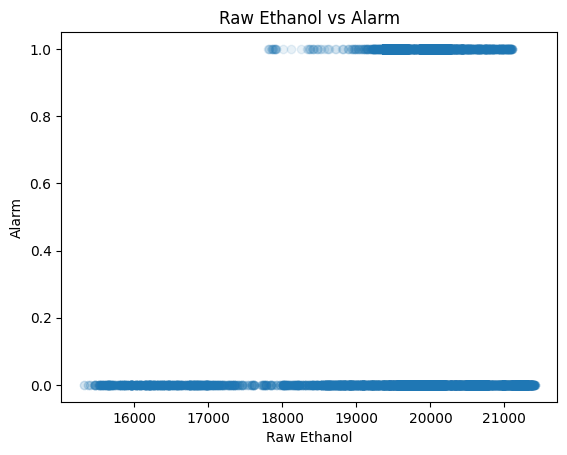

Pressure[hPa]


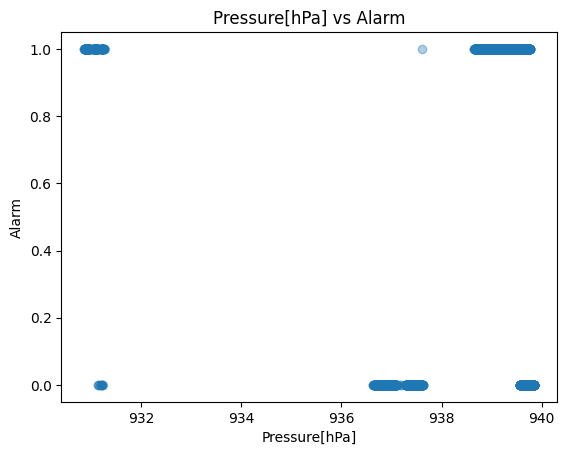

PM1.0


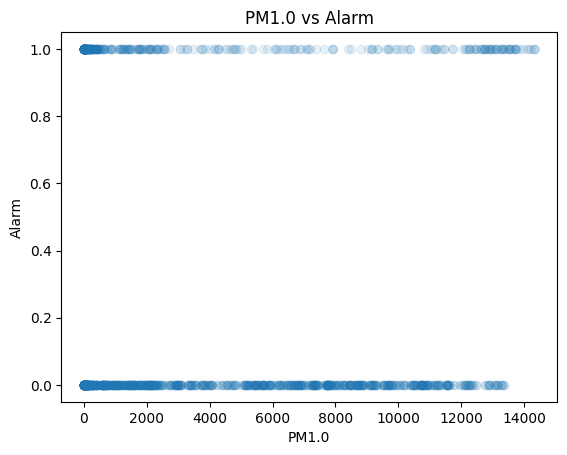

PM2.5


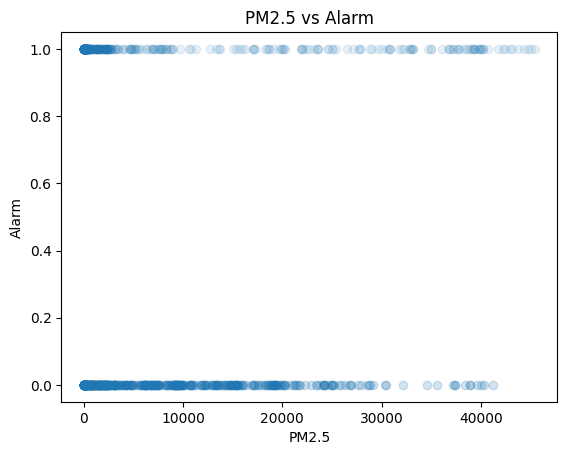

NC0.5


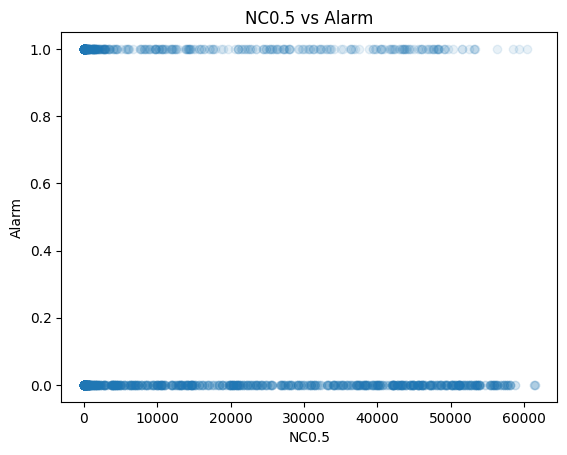

NC1.0


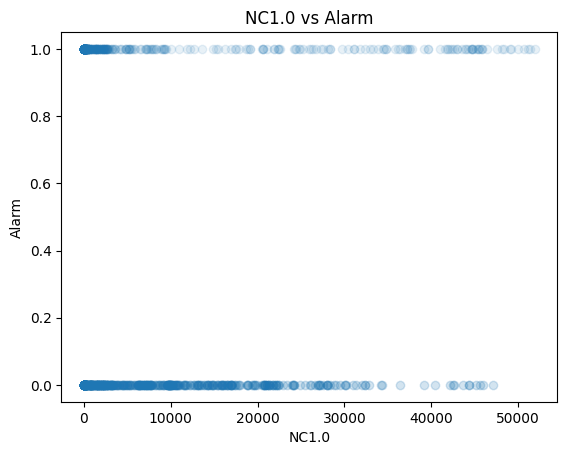

NC2.5


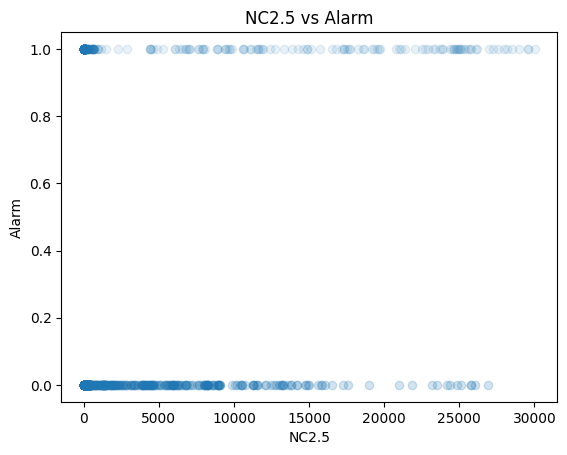

CNT


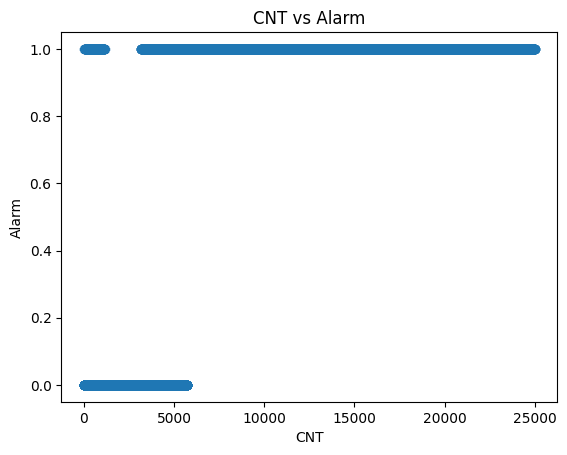

In [14]:
for feature in features:
    print(feature)
    plt.scatter(df[feature], y, alpha=0.1)
    plt.title(feature + " vs Alarm")
    plt.xlabel(feature)
    plt.ylabel("Alarm")
    plt.show()

Note: expecting to see a clear cutoff between some of the features vs alarm on or off. For instance, positive smoke detection at ethanol approximately 18000. Some data did not give a clear cutoff. Most likely, more than one factors are used to determine when the alarm goes off or not.

#### Correlation between each different feature with alarm

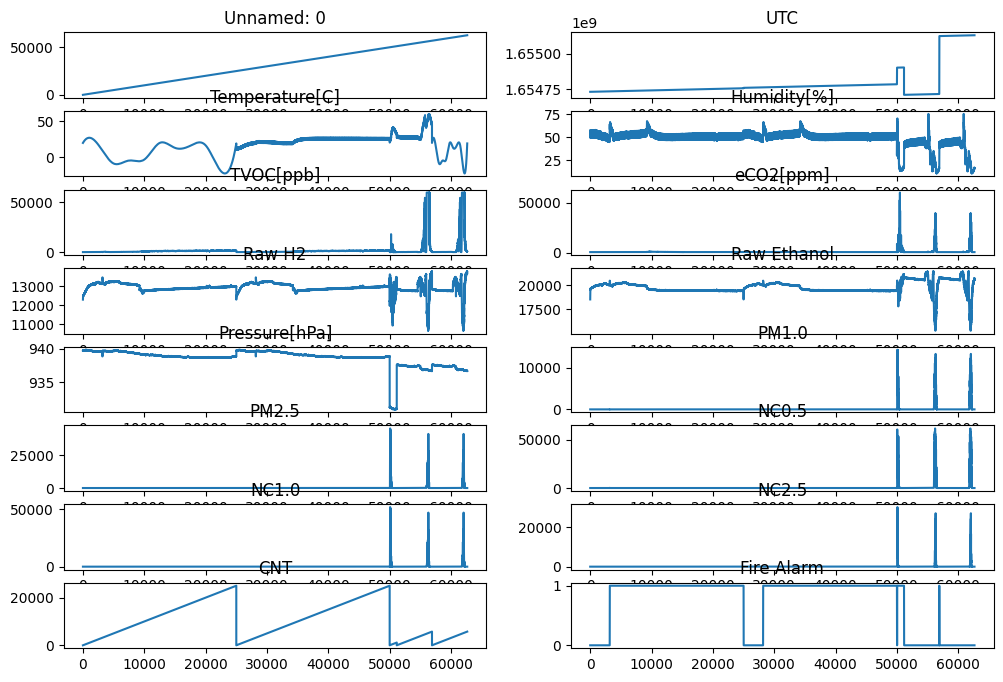

In [15]:
# get the column names
columns = df.columns

# calculate the number of rows required
nrows = (len(columns) + 1) // 2

# create a figure object
fig = plt.figure(figsize=(12, 8))

# use a for loop to plot each column
for i, col in enumerate(columns):
    ax = fig.add_subplot(nrows, 2, i+1)
    df[col].plot(kind='line', ax=ax)
    ax.set_title(col)

# show the plot
plt.show()

In [16]:
# TO BE REMOVED (duplate from above)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,62630.0,3.131450e+04,18079.868017,0.000000e+00,1.565725e+04,3.131450e+04,4.697175e+04,6.262900e+04
UTC,62630.0,1.654792e+09,110002.488078,1.654712e+09,1.654743e+09,1.654762e+09,1.654778e+09,1.655130e+09
Temperature[C],62630.0,1.597042e+01,14.359576,-2.201000e+01,1.099425e+01,2.013000e+01,2.540950e+01,5.993000e+01
Humidity[%],62630.0,4.853950e+01,8.865367,1.074000e+01,4.753000e+01,5.015000e+01,5.324000e+01,7.520000e+01
TVOC[ppb],62630.0,1.942058e+03,7811.589055,0.000000e+00,1.300000e+02,9.810000e+02,1.189000e+03,6.000000e+04
eCO2[ppm],62630.0,6.700210e+02,1905.885439,4.000000e+02,4.000000e+02,4.000000e+02,4.380000e+02,6.000000e+04
Raw H2,62630.0,1.294245e+04,272.464305,1.066800e+04,1.283000e+04,1.292400e+04,1.310900e+04,1.380300e+04
Raw Ethanol,62630.0,1.975426e+04,609.513156,1.531700e+04,1.943500e+04,1.950100e+04,2.007800e+04,2.141000e+04
Pressure[hPa],62630.0,9.386276e+02,1.331344,9.308520e+02,9.387000e+02,9.388160e+02,9.394180e+02,9.398610e+02
PM1.0,62630.0,1.005943e+02,922.524245,0.000000e+00,1.280000e+00,1.810000e+00,2.090000e+00,1.433369e+04


Should we remove outliers?

In [17]:
#DATA TYPE
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [18]:
target = ['Fire Alarm']
features = ['Unnamed: 0', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]',
       'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5',
       'NC0.5', 'NC1.0', 'NC2.5', 'CNT']

In [19]:
df.columns

Index(['Unnamed: 0', 'UTC', 'Temperature[C]', 'Humidity[%]', 'TVOC[ppb]',
       'eCO2[ppm]', 'Raw H2', 'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5',
       'NC0.5', 'NC1.0', 'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

## Spliting Data

In [20]:
# set time t
t = 5 #seconds

In [21]:
length = len(df)
df_train = df.head(int(length*0.8))[features + target]
df_test = df.tail(length- int(length*0.8))[features + target]

In [22]:
#reset the indices for cleanliness
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [23]:
df_train

,index,Unnamed: 0,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0,0
1,1,1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,1,0
2,2,2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,2,0
3,3,3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,3,0
4,4,4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50099,50099,50099,23.070,57.92,424,1539,12927,19552,931.221,10279.24,20107.56,47060.27,22307.672,9400.648,111,1
50100,50100,50100,23.230,58.92,377,1426,12983,19597,931.224,11443.02,23448.11,49714.79,26105.840,11497.828,112,1
50101,50101,50101,23.410,59.04,396,1390,13000,19584,931.227,11708.23,24642.21,49232.19,27489.051,12395.891,113,1
50102,50102,50102,23.370,59.34,394,1416,12981,19568,931.230,12046.91,26516.15,47738.91,29672.891,13881.570,114,1


In [24]:
df_test

,index,Unnamed: 0,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,50104,50104,23.310,60.13,400,1379,13004,19571,931.228,12479.08,28838.30,46007.05,32376.953,15710.273,116,1
1,50105,50105,23.280,60.52,401,1363,13013,19582,931.228,12639.26,30090.07,44382.60,33846.906,16767.688,117,1
2,50106,50106,23.270,60.86,397,1372,13012,19579,931.225,12694.37,30579.66,43675.57,34423.105,17188.703,118,1
3,50107,50107,23.270,61.17,399,1416,12985,19571,931.224,12797.70,31769.10,41668.08,35828.141,18241.555,119,1
4,50108,50108,23.280,61.71,399,1375,13014,19574,931.219,12857.14,32268.64,40977.19,36415.520,18667.953,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12521,62625,62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,5739,0
12522,62626,62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,5740,0
12523,62627,62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,5741,0
12524,62628,62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,5742,0


In [25]:
# we'll start out with a 5 minute input sequence and a one minute predictive horizon
seq_length = 5
ph = 1 #predictive horizon

feat_cols = features

#create list of sequence length alarm readings
sequences = [df_train[i:i+seq_length+ph] for i in range(len(df_train)-seq_length-ph)]

#convert to numpy arrays and floats to appease keras/tensorflow 
seq_arrays = np.array([val[features].head(seq_length) for val in sequences])
seq_labs = np.array([val[target[0]].iloc[-1] for val in sequences])

In [26]:
seq_arrays.shape

(50098, 5, 14)

In [27]:
seq_labs.shape

(50098,)

## Model 

## References:

1. "Fire Death and Injury Risk". US Fire Administration. https://www.usfa.fema.gov/statistics/deaths-injuries/
2. Hanacek, N. "How Do Smoke Detectors Work?" https://www.nist.gov/how-do-you-measure-it/how-do-smoke-detectors-work